In [22]:
from config import BASE_DIR
import pandas as pd
BASELINE_DIR = f"{BASE_DIR}/reports/baselines"


In [23]:
import os
filenames = []
for root, dirs, files in os.walk(BASELINE_DIR):
    for file in files:
        filenames.append(file)
filenames

['composition_unsupervised.csv',
 'section_supervised.csv',
 'section_unsupervised.csv',
 'book_unsupervised.csv',
 'composition_supervised.csv',
 'book_supervised.csv']

In [24]:
pd.read_csv(f"{BASELINE_DIR}/book_supervised.csv")

,model,accuracy,micro_precision,micro_recall,micro_f1,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,vectorizer
0,MLPClassifier,0.509158,0.509158,0.509158,0.509158,0.385795,0.369422,0.363113,0.477562,0.509158,0.479332,yonatanlou/BEREL-finetuned-DSS-maskedLM
1,LogisticRegression,0.490842,0.490842,0.490842,0.490842,0.351654,0.353281,0.338018,0.440226,0.490842,0.448215,yonatanlou/BEREL-finetuned-DSS-maskedLM
2,LogisticRegression,0.476190,0.476190,0.476190,0.476190,0.318753,0.347201,0.322888,0.420416,0.476190,0.438009,yonatanlou/BEREL-finetuned-DSS-composition-cla...
3,MLPClassifier,0.468864,0.468864,0.468864,0.468864,0.357597,0.360736,0.344576,0.453156,0.468864,0.447291,yonatanlou/BEREL-finetuned-DSS-composition-cla...
4,LogisticRegression,0.465201,0.465201,0.465201,0.465201,0.323297,0.324608,0.309047,0.415022,0.465201,0.417417,dicta-il/BEREL
...,...,...,...,...,...,...,...,...,...,...,...,...
61,AdaBoostClassifier,0.117216,0.117216,0.117216,0.117216,0.034665,0.040185,0.032083,0.051229,0.117216,0.055937,trigram
62,AdaBoostClassifier,0.113553,0.113553,0.113553,0.113553,0.003082,0.017690,0.005119,0.020012,0.113553,0.033186,dicta-il/BEREL
63,AdaBoostClassifier,0.113553,0.113553,0.113553,0.113553,0.051972,0.049805,0.044715,0.073078,0.113553,0.060341,tfidf
64,AdaBoostClassifier,0.095238,0.095238,0.095238,0.095238,0.020913,0.035556,0.022753,0.036885,0.095238,0.037180,dicta-il/dictabert-large


In [25]:
pd.read_csv(f"{BASELINE_DIR}/composition_supervised.csv")

,model,accuracy,micro_precision,micro_recall,micro_f1,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,vectorizer
0,MLPClassifier,0.717791,0.717791,0.717791,0.717791,0.699637,0.626460,0.631972,0.746513,0.717791,0.714774,onlplab/alephbert-base
1,MLPClassifier,0.711656,0.711656,0.711656,0.711656,0.636488,0.607903,0.605181,0.708218,0.711656,0.700728,yonatanlou/BEREL-finetuned-DSS-maskedLM
2,LogisticRegression,0.711656,0.711656,0.711656,0.711656,0.675395,0.593991,0.605253,0.716825,0.711656,0.696326,dicta-il/dictabert-large
3,LinearSVC,0.711656,0.711656,0.711656,0.711656,0.672442,0.632077,0.638366,0.723196,0.711656,0.709600,dicta-il/dictabert-large
4,LogisticRegression,0.711656,0.711656,0.711656,0.711656,0.639046,0.586876,0.593149,0.715879,0.711656,0.700188,yonatanlou/BEREL-finetuned-DSS-maskedLM
...,...,...,...,...,...,...,...,...,...,...,...,...
61,AdaBoostClassifier,0.233129,0.233129,0.233129,0.233129,0.025924,0.079426,0.037157,0.081504,0.233129,0.115184,dicta-il/BEREL
62,AdaBoostClassifier,0.208589,0.208589,0.208589,0.208589,0.093537,0.104545,0.081718,0.092711,0.208589,0.104171,trigram
63,AdaBoostClassifier,0.208589,0.208589,0.208589,0.208589,0.083185,0.122727,0.086565,0.094591,0.208589,0.103422,tfidf
64,AdaBoostClassifier,0.208589,0.208589,0.208589,0.208589,0.070916,0.123535,0.073545,0.122775,0.208589,0.126162,dicta-il/dictabert-large


In [26]:
pd.read_csv(f"{BASELINE_DIR}/section_supervised.csv")

,model,accuracy,micro_precision,micro_recall,micro_f1,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,vectorizer
0,MLPClassifier,0.971098,0.971098,0.971098,0.971098,0.979643,0.902137,0.932831,0.971807,0.971098,0.969385,yonatanlou/BEREL-finetuned-DSS-sectarian-class...
1,LinearSVC,0.959538,0.959538,0.959538,0.959538,0.966977,0.889096,0.919981,0.960555,0.959538,0.957980,yonatanlou/BEREL-finetuned-DSS-sectarian-class...
2,LogisticRegression,0.959538,0.959538,0.959538,0.959538,0.974432,0.867911,0.908111,0.960851,0.959538,0.956787,yonatanlou/BEREL-finetuned-DSS-sectarian-class...
3,LinearSVC,0.953757,0.953757,0.953757,0.953757,0.940983,0.865286,0.895914,0.952504,0.953757,0.951226,dicta-il/BEREL
4,LogisticRegression,0.953757,0.953757,0.953757,0.953757,0.964531,0.865286,0.901816,0.955167,0.953757,0.951108,yonatanlou/BEREL-finetuned-DSS-maskedLM
...,...,...,...,...,...,...,...,...,...,...,...,...
61,RandomForestClassifier,0.815029,0.815029,0.815029,0.815029,0.839616,0.539311,0.553219,0.823292,0.815029,0.783485,starr
62,MLPClassifier,0.797688,0.797688,0.797688,0.797688,0.737615,0.490286,0.534168,0.794497,0.797688,0.756687,starr
63,LogisticRegression,0.768786,0.768786,0.768786,0.768786,0.787792,0.506140,0.553615,0.767994,0.768786,0.740034,starr
64,LinearSVC,0.699422,0.699422,0.699422,0.699422,0.561097,0.507030,0.487663,0.743201,0.699422,0.700119,starr


In [45]:
gnn_results = pd.read_csv(f"{BASE_DIR}/reports/gnn/gcn_baseline_composition_100_words_4_adj_types.csv").sort_values(by="test_acc",ascending=False)
gnn_results["num_adj_type"] = gnn_results["adj_type"].str.split(" & ").apply(len)
gnn_results

,epoch,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc,micro_precision,micro_recall,micro_f1,...,num_adjs,epochs,hidden_dim,distance,learning_rate,threshold,bert_model,adj_type,num_edges,num_adj_type
0,110,0.322267,0.890411,0.752124,0.753846,0.730788,0.791411,0.791411,0.791411,0.791411,...,3,500,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-maskedLM,tfidf & trigram & BOW-n_gram,6594,3
1,83,0.418754,0.878425,0.771248,0.723077,0.803214,0.766871,0.766871,0.766871,0.766871,...,2,500,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-maskedLM,trigram & BOW-n_gram,6594,2
2,76,0.449857,0.878425,0.869978,0.723077,0.831282,0.760736,0.760736,0.760736,0.760736,...,2,500,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-maskedLM,tfidf & trigram,6594,2
3,96,0.317829,0.886986,0.829391,0.723077,0.828378,0.760736,0.760736,0.760736,0.760736,...,3,500,300,cosine,0.001,0.99,dicta-il/BEREL,tfidf & trigram & BOW-n_gram,6594,3
4,78,0.326892,0.888699,0.706863,0.753846,0.829035,0.760736,0.760736,0.760736,0.760736,...,3,500,300,cosine,0.001,0.99,onlplab/alephbert-base,tfidf & trigram & BOW-n_gram,6594,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,24,1.079499,0.690068,1.388325,0.538462,1.564585,0.496933,0.496933,0.496933,0.496933,...,2,500,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-composition-cla...,BOW-n_gram & topic_modeling_lda,6594,2
220,24,1.079499,0.690068,1.388325,0.538462,1.564585,0.496933,0.496933,0.496933,0.496933,...,2,500,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-composition-cla...,trigram & topic_modeling_lda,6594,2
221,24,1.079499,0.690068,1.388325,0.538462,1.564585,0.496933,0.496933,0.496933,0.496933,...,2,500,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-composition-cla...,tfidf & topic_modeling_lda,6594,2
222,24,1.079499,0.690068,1.388325,0.538462,1.564585,0.496933,0.496933,0.496933,0.496933,...,1,500,300,cosine,0.001,0.99,yonatanlou/BEREL-finetuned-DSS-composition-cla...,topic_modeling_lda,6594,1


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Calculate the number of adjectives

def create_box_plot(results_df, x, y):
    plt.figure(figsize=(10, 6))
    
    # Calculate the median values for each category in x
    medians = results_df.groupby(x)[y].median().sort_values()
    
    # Reorder the categories in the DataFrame
    results_df[x] = pd.Categorical(results_df[x], categories=medians.index, ordered=True)
    
    # Create the box plot
    ax = sns.boxplot(x=x, y=y, data=results_df, palette="Set3")
    
    # Add title and labels
    ax.set_title(f'Test {y} by different of {x}', fontsize=16)
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(f'Test {y}', fontsize=14)
    
    # Show the plot
    plt.xticks(rotation=90)
    plt.show()

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=x, y=y, data=results_df, palette="Set3")


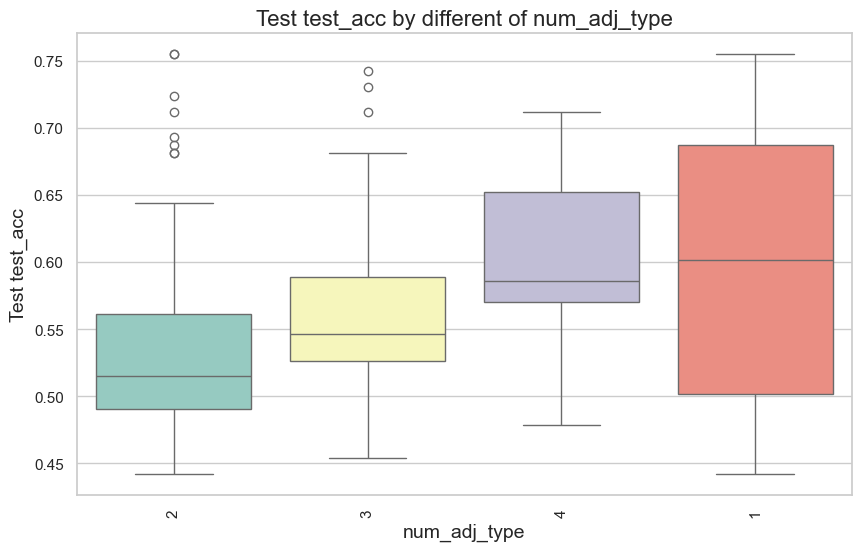

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=x, y=y, data=results_df, palette="Set3")


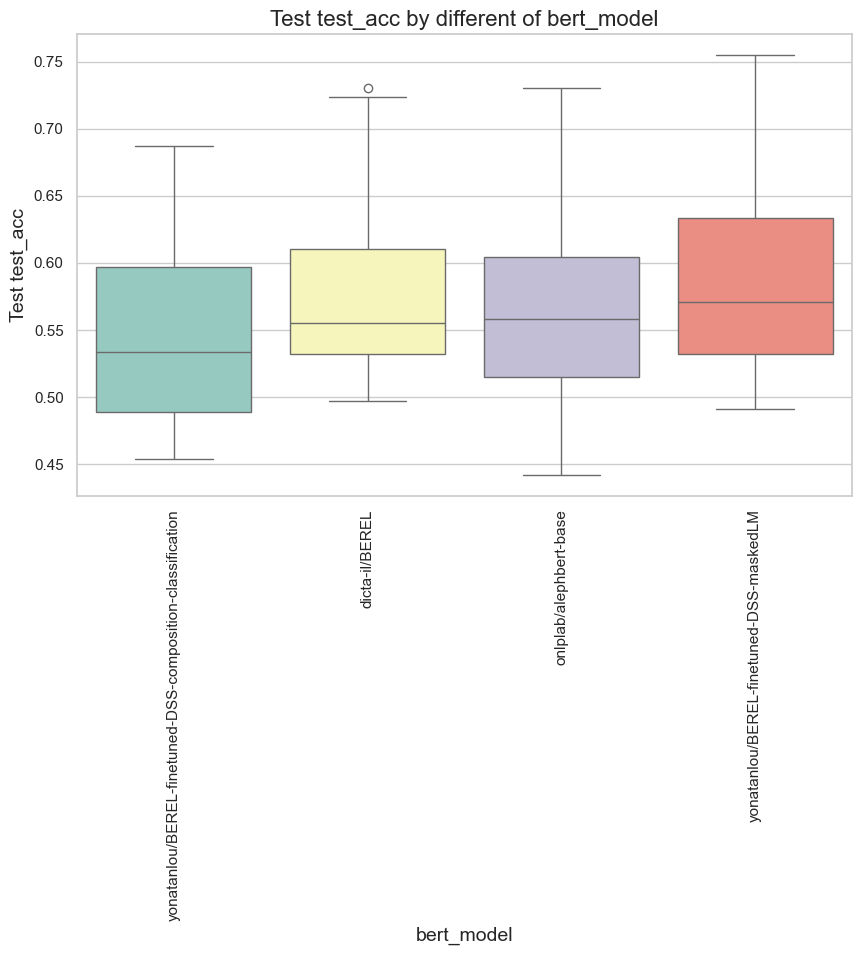

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=x, y=y, data=results_df, palette="Set3")


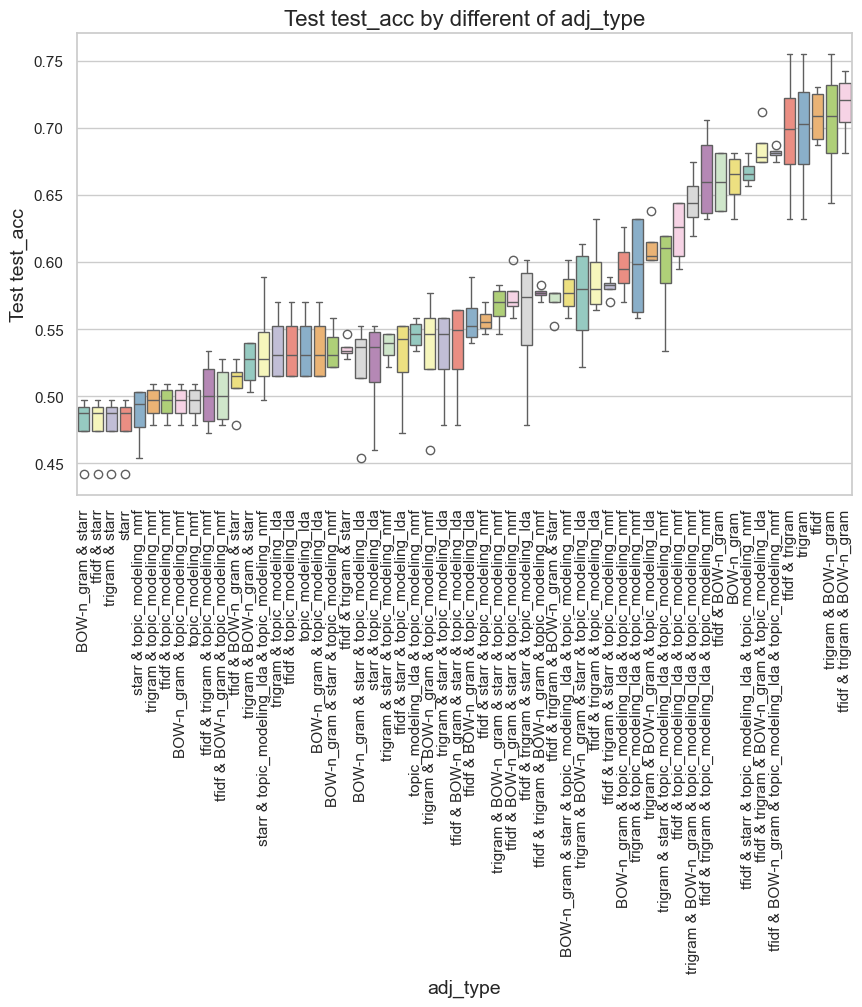

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = results_df.groupby(x)[y].median().sort_values()
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=x, y=y, data=results_df, palette="Set3")


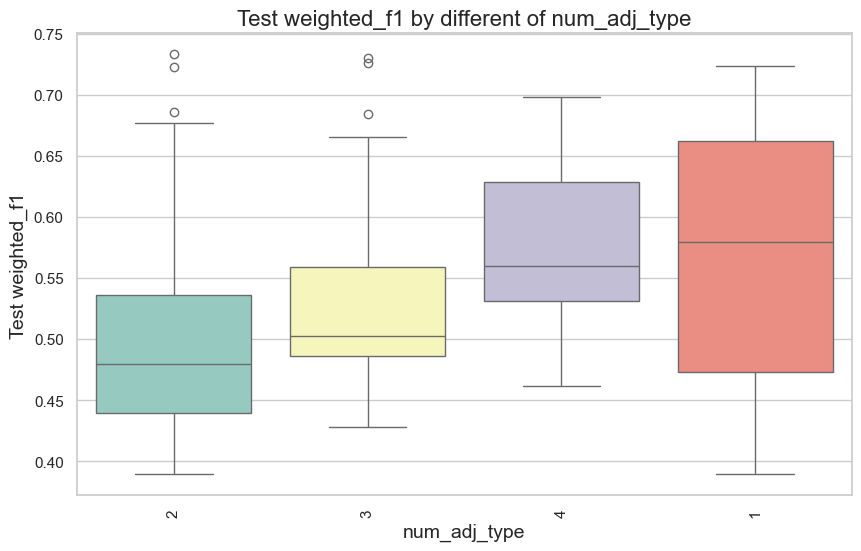

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = results_df.groupby(x)[y].median().sort_values()
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=x, y=y, data=results_df, palette="Set3")


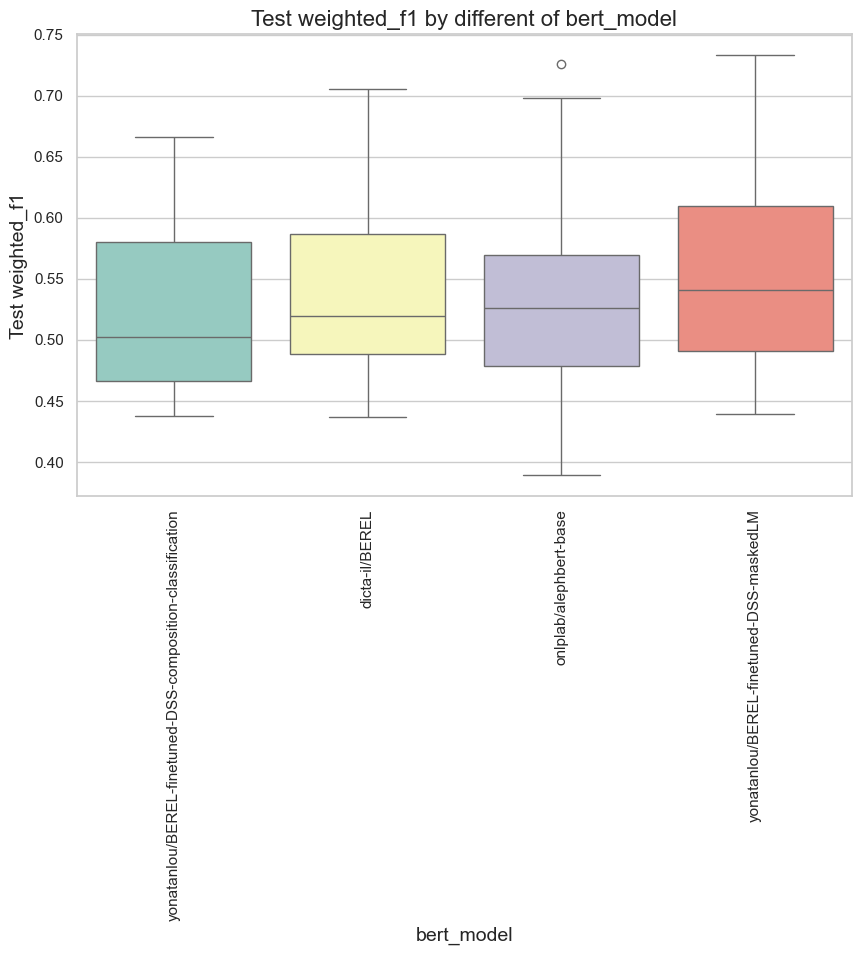

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = results_df.groupby(x)[y].median().sort_values()
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_22213/458117474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=x, y=y, data=results_df, palette="Set3")


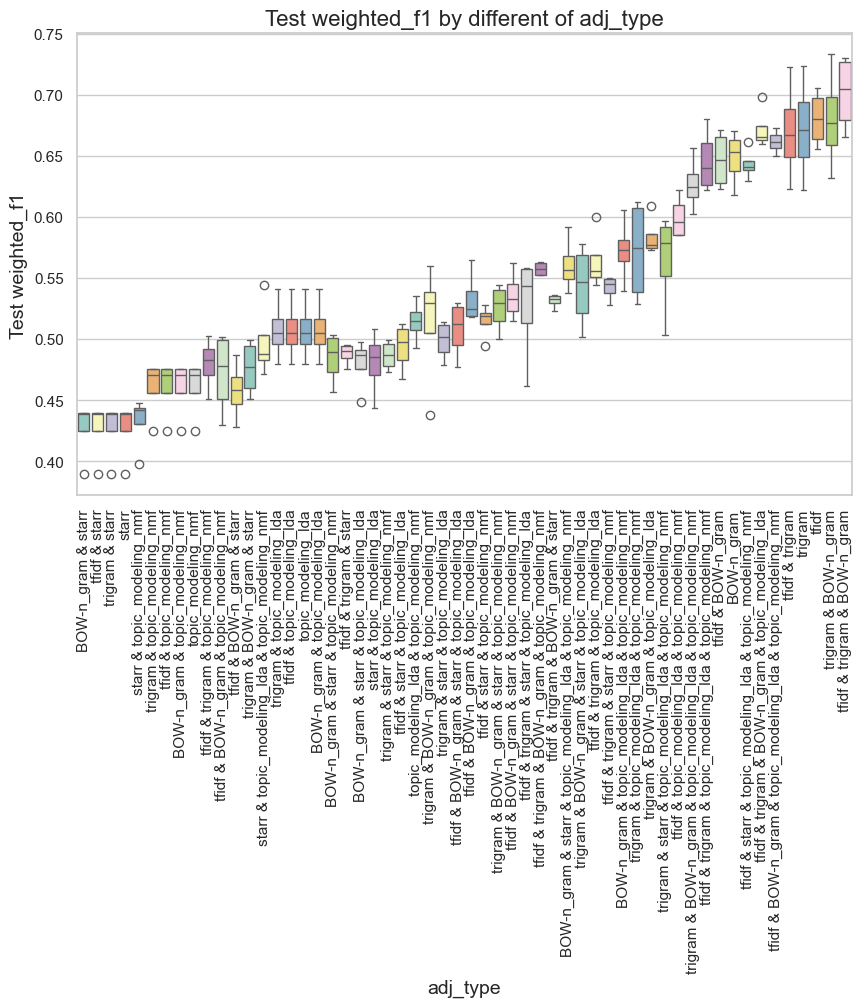

In [43]:
for metric in ["test_acc","weighted_f1"]:
    for param in ["num_adj_type",  "bert_model", "adj_type"]:
        create_box_plot(gnn_results,param, metric)